# TODO

- Clean up code
  - Function for plotting
  - Better setup for indexing
- Add math 

$$
\begin{bmatrix}
x \\
y \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
x \\
0 \\
0 \\
y \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
$$


# Load data

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

from iterativennsimple.Sequential2D import Sequential2D, Identity
from iterativennsimple.Sequential1D import Sequential1D

from iterativennsimple.utils.plot_2D_start_end import plot_2D_start_end

In [2]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [3]:
#name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
#name = 'regression_circle'
#one_hot_y = False

name = 'MNIST'
one_hot_y = True

# Read the start data
z_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
z_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')

## Data preprocessing

In [4]:
z_start_tensor = df_to_tensor(z_start)
z_target_tensor = df_to_tensor(z_target)

# Only use the given number of sample
max_num_samples = 1000
num_samples = min(max_num_samples, z_start_tensor.shape[0])
z_start_tensor = z_start_tensor[:num_samples]
z_target_tensor = z_target_tensor[:num_samples]

# compute a mask for the data where every entry in each column is the same
# this is used to remove columns that are constant
mask = (z_start_tensor == z_target_tensor).all(axis=0)
mask.shape
x_mask = mask
y_mask = ~mask

# print out the shape of the masks
print(x_mask.shape, y_mask.shape)

# print out number of true entries in each mask
print(x_mask.sum(), y_mask.sum())


torch.Size([794]) torch.Size([794])
tensor(784) tensor(10)


# MLP model

In [5]:
input_size = int(x_mask.sum())
h1_size = 20
h2_size = 20
output_size = int(y_mask.sum())

x_idx = torch.arange(0, input_size)
h_idx = torch.arange(input_size, input_size+h1_size+h2_size)
y_idx = torch.arange(input_size+h1_size+h2_size, input_size+h1_size+h2_size+output_size)

total_size = input_size + h1_size + h2_size + output_size

iterations = 3

I = Identity(in_features=input_size, out_features=input_size)
f1 = Sequential1D(torch.nn.Linear(in_features=input_size, out_features=h1_size), 
                  torch.nn.ReLU(), 
                  in_features=input_size, out_features=h1_size)
f2 = Sequential1D(torch.nn.Linear(in_features=h1_size, out_features=h2_size), 
                  torch.nn.ReLU(), 
                  in_features=h1_size,    out_features=h2_size)
f3 = torch.nn.Linear(in_features=h2_size,    out_features=output_size)    

in_features_list  = [input_size, h1_size, h2_size, output_size]
out_features_list = [input_size, h1_size, h2_size, output_size]
blocks = [[I,    None, None, None],
          [f1,   None, None, None],
          [None, f2,   None, None],
          [None, None, f3,   None]]

def transpose_blocks(blocks):
    return [[blocks[j][i] for j in range(len(blocks))] for i in range(len(blocks[0]))]

map = Sequential2D(
    in_features_list=in_features_list,
    out_features_list=out_features_list,
    blocks=transpose_blocks(blocks)
)   

In [6]:
zh_start_tensor = torch.cat((z_start_tensor[:, x_mask],
                             torch.zeros(z_start_tensor.shape[0], len(h_idx)), 
                             z_start_tensor[:, y_mask]), dim=1)
zh_target_tensor = torch.cat((z_target_tensor[:, x_mask], 
                             torch.zeros(z_target_tensor.shape[0], len(h_idx)), 
                             z_target_tensor[:, y_mask]), dim=1)

In [7]:
# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, z_start, z_target):
        self.z_start = z_start
        self.z_target = z_target
    def __len__(self):
        return len(self.z_start)
    def __getitem__(self, idx):
        return self.z_start[idx], self.z_target[idx]
    
train_data = Data(zh_start_tensor, zh_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [8]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [9]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()

        mapped = start

        loss = 0.0
        for i in range(iterations):
            mapped = map(mapped)

        loss = criterion(mapped[:, y_idx], target[:, y_idx])
        loss.backward()

        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 0.0930650532245636
Epoch 100, Batch 9, Loss 0.013849847950041294
Epoch 200, Batch 9, Loss 0.004972574766725302
Epoch 300, Batch 9, Loss 0.0022842686157673597
Epoch 400, Batch 9, Loss 0.003693745471537113


# Training data

In [10]:
def project(z_start, z_mapped, z_target, idx, one_hot=False):
    if len(idx) == 1:
        start = z_start[:, idx[0]]
        target = z_target[:, idx[0]]
        mapped = z_mapped[:, idx[0]]
    else:
        if one_hot:
            start = torch.argmax(z_start[:, idx], dim=1)
            target = torch.argmax(z_target[:, idx], dim=1)
            mapped = torch.argmax(z_mapped[:, idx], dim=1)
        else:
            # Use PCA to reduce the dimensionality of the data
            _, _, V = torch.svd(z_target[:, idx])
            start = torch.matmul(z_start[:, idx], V[:, 0])
            target = torch.matmul(z_target[:, idx], V[:, 0])
            mapped = torch.matmul(z_mapped[:, idx], V[:, 0])
    return start, mapped, target


def my_plot(z_start, z_mapped, z_target, plot_points, x_idx, y_idx, one_hot_y=False):
    start_x, mapped_x, target_x = project(z_start, z_mapped, z_target, x_idx)
    start_y, mapped_y, target_y = project(z_start, z_mapped, z_target, y_idx, one_hot_y)
    plot_2D_start_end(start_x, start_y,
                      mapped_x, mapped_y, 
                      target_x, target_y, 
                      plot_points)

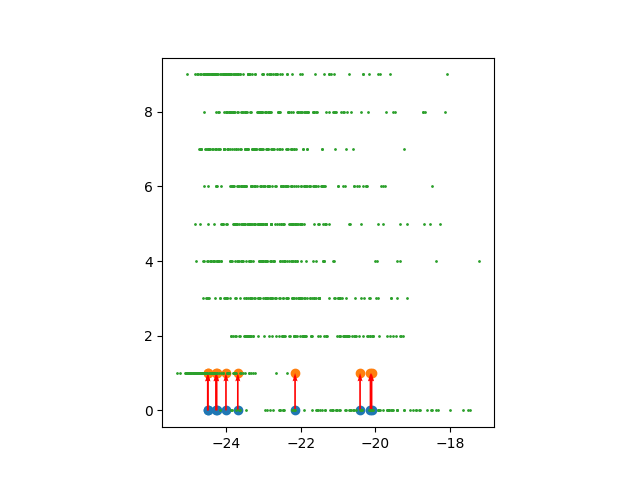

In [11]:
# Hemingway bridge:  This looks strange.  Need to think about how to plot.

plot_iterations = 1

mapped_tensor = zh_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

my_plot(zh_start_tensor, mapped_tensor, zh_target_tensor, plot_points=10, x_idx=x_idx, y_idx=y_idx, one_hot_y=one_hot_y)


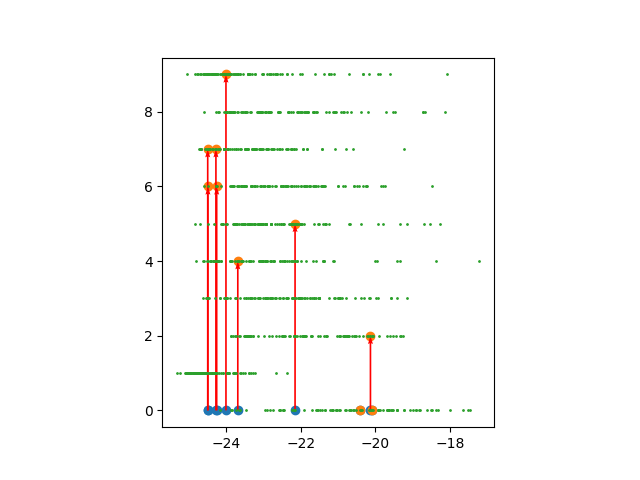

In [12]:
plot_iterations = iterations

mapped_tensor = zh_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

my_plot(zh_start_tensor, mapped_tensor, zh_target_tensor, plot_points=10, x_idx=x_idx, y_idx=y_idx, one_hot_y=one_hot_y)

# Path

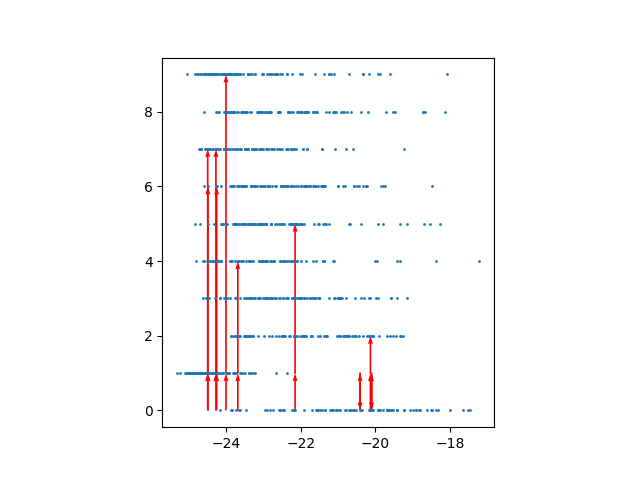

In [13]:
plot_points = 10


mapped_tensors = [zh_start_tensor[:plot_points, :]]
for i in range(iterations):
    mapped_tensors.append(map(mapped_tensors[i]).detach())


plt.figure()

for i, mapped_tensor in enumerate(mapped_tensors):
    if i > 0:
        start = mapped_tensors[i-1]
        mapped = mapped_tensors[i]

        start_x, mapped_x, target_x = project(start, mapped, zh_target_tensor, idx=x_idx)
        start_y, mapped_y, target_y = project(start, mapped, zh_target_tensor, idx=y_idx, one_hot=one_hot_y)

        dx = mapped_x-start_x
        dy = mapped_y-start_y
        plt.quiver(start_x, start_y, dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(target_x, target_y, s=1)

plt.gca().set_aspect('equal')
plt.show()

# Testing data

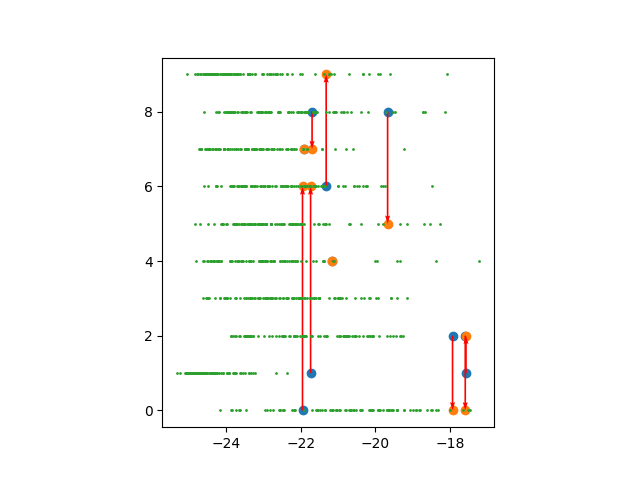

In [14]:
zh_start_tensor_test = zh_start_tensor+torch.rand_like(zh_start_tensor)*0.2
mapped_tensor = zh_start_tensor_test
for i in range(iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

my_plot(zh_start_tensor_test, mapped_tensor, zh_target_tensor, plot_points=10, x_idx=x_idx, y_idx=y_idx, one_hot_y=one_hot_y)


In [15]:
for i in torch.randperm(zh_start_tensor.shape[0])[:5]:
    print(f'i = {i}')    
    print(zh_start_tensor_test[i,y_idx])
    print(mapped_tensor[i,y_idx])
    print(zh_target_tensor[i,y_idx])
    print(f'{torch.argmax(zh_start_tensor_test[i,y_idx])} -> {torch.argmax(mapped_tensor[i,y_idx])} -> {torch.argmax(zh_target_tensor[i,y_idx])}')



i = 616
tensor([0.2587, 0.2308, 0.2372, 0.1152, 0.2973, 0.2983, 0.1643, 0.2475, 0.2561,
        0.1611])
tensor([ 0.0143,  0.0691,  0.0326, -0.0181, -0.0253,  0.0135,  0.0033,  0.0053,
         0.8662,  0.0416])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
5 -> 8 -> 8
i = 602
tensor([0.1970, 0.1306, 0.2896, 0.1414, 0.1265, 0.2581, 0.1753, 0.2469, 0.2945,
        0.2389])
tensor([-0.0033,  0.0934,  0.0092,  0.9530, -0.0092, -0.0421,  0.0023,  0.0030,
        -0.0098,  0.0079])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
8 -> 3 -> 3
i = 477
tensor([0.2236, 0.1001, 0.2406, 0.1489, 0.2006, 0.1123, 0.2123, 0.1201, 0.2518,
        0.1496])
tensor([ 0.0094,  0.1126,  0.0198, -0.0155, -0.0062, -0.0871,  0.0070,  0.0062,
         0.9398,  0.0150])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
8 -> 8 -> 8
i = 744
tensor([0.1484, 0.1349, 0.2769, 0.2606, 0.2674, 0.1847, 0.1948, 0.2340, 0.1745,
        0.1703])
tensor([ 0.0049,  0.1818,  0.0018, -0.0127,  0.0125, -0.1713,  0.0314,  0.01